In [7]:
import numpy as np
import random

class GridWorld:
    # call to initialize grid world enviroment, default will be a 5x5 grid with a start point at the top left corner and goal at
    # the bottom right corner, no obsticals, if probablity of obsticals is given, these will be placed in enviroment randomly
    def __init__(self, grid_size=(5, 5), start_point=(0, 0), goal_point=None, prob_obstacle=0):
        self.grid_size = grid_size
        self.start_point = start_point
        self.goal_point = goal_point if goal_point is not None else (grid_size[0] - 1, grid_size[1] - 1)
        self.prob_obstacle = prob_obstacle

        self.action_map = ['up', 'down', 'left', 'right']
        self.reset()

    def reset(self):
        self.agent_point = self.start_point
        self.grid = np.zeros(self.grid_size, dtype=int)  # 0 for free, 1 for obstacle

        if self.prob_obstacle > 0:
            for r in range(self.grid_size[0]):
                for c in range(self.grid_size[1]):
                    if random.random() < self.prob_obstacle and (r, c) != self.start_point and (r, c) != self.goal_point:
                        self.grid[r, c] = 1

        return self.agent_point

    def step(self, action_idx):
        action = self.action_map[action_idx]
        x, y = self.agent_point
        next_x, next_y = x, y

        if action == 'up' and x > 0:
            next_x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            next_x += 1
        elif action == 'left' and y > 0:
            next_y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            next_y += 1

        # If next cell is an obstacle, stay in place
        if self.grid[next_x, next_y] == 1:
            next_x, next_y = x, y

        self.agent_point = (next_x, next_y)
        done = self.is_at_goal()
        reward = 10 if done else -1
        return self.agent_point, reward, done, {}

    def is_at_goal(self):
        return self.agent_point == self.goal_point


In [139]:
class QLearningAgent:
    def __init__(self, grid_size, action_size=4, alpha=0.1, gamma=0, epsilon=0, epsilon_min=0.01, epsilon_decay=0):
        """
        Initialize the Q-learning agent.
        Args:
            grid_size: Size of the grid (grid_size x grid_size)
            action_size: Size of the action space (default 4: up, right, down, left)
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Decay rate for exploration
        """
        
        self.grid_size = grid_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table with zeros
        # Q-table shape: (grid_size, grid_size, action_size)

        self.q_table = np.zeros((grid_size[0], grid_size[1], action_size))

    def get_action(self, state, training=True):
        """
        Get action for the given state using epsilon-greedy policy.
        Args:
            state: Current state (x, y)
            training: Whether we're in training mode (use epsilon-greedy) or not
        Returns:
            action: Selected action
        """
        x, y = state
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # Exploration: choose a random action
        else:
            return np.argmax(self.q_table[x, y])        # Exploitation: choose the best action from Q-table

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-table using the Q-learning update rule.
        Args:
            state: Current state (x, y)
            action: Action taken
            reward: Reward received
            next_state: Next state (x, y)
            done: Whether the episode is done
        """
        x, y = state
        next_x, next_y = next_state
        
        # Q-learning update rule
        # Q(s,a) = Q(s,a) + alpha * [r + gamma * max(Q(s',a')) - Q(s,a)]
        
        if not done:
            target = reward + self.gamma * np.max(self.q_table[next_x, next_y])
        else:
            target = reward
            
        current = self.q_table[x, y, action]
        self.q_table[x, y, action] = current + self.alpha * (target - current)

    def decay_epsilon(self):
        """Decay exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [92]:
import os
import time

def train(env, agent, episodes=500, max_steps=100):
    """
    Train the agent in the environment.
    Args:
        env: GridWorldEnv instance
        agent: QLearningAgent instance
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
    """

    rewards = []
    steps_list = []
    start_time = time.time()

    for episode in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            action = agent.get_action(state)                         # Get action
            next_state, reward, done, _ = env.step(action)           # Take step
            agent.update(state, action, reward, next_state, done)    # Update Q-table

            # Update state and total reward
            state = next_state
            total_reward += reward

            if done:
                break

        # Decay exploration rate
        agent.decay_epsilon()
        
        # Save rewards and steps
        rewards.append(total_reward)
        steps_list.append(step + 1)

        log_interval=500
        # Log progress
        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_steps = np.mean(steps_list[-log_interval:])
            print(f"Episode {episode}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Epsilon: {agent.epsilon:.4f}")

    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")

    return rewards, steps_list

In [35]:
def evaluate(env, agent, episodes=10, max_steps=100, render=True):
    rewards, steps_list, sucesses, success_count = [], [], [], 0
    for ep in range(episodes):
        state, total_reward, done = env.reset(), 0, False
        path = [state]
        for step in range(max_steps):
            action = agent.get_action(state, training=False)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(state)
            total_reward += reward
            if done:
                if reward > 0: success_count += 1
                break
        wasSucess = reward > 0
        sucesses.append(wasSucess)
        rewards.append(total_reward)
        steps_list.append(step + 1)

        print(f"Episode {ep+1}/{episodes} | Reward: {total_reward} | Steps: {step + 1}")
    print(f"\nSuccess Rate: {success_count / episodes * 100:.2f}%")

    return rewards, steps_list, sucesses

In [104]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_training_progress(rewards, steps):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Rewards per Episode")
    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.title("Steps per Episode")
    plt.savefig('training_progress.png')
    plt.show()
    
def plot_rewards(rewards):
    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label='Reward per Episode')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.title("Total Reward per Evaluation Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_convergence(success, window=5):
    episodes = len(success)
    moving_avg_success = np.convolve(success, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(8, 4))
    plt.plot(range(window-1, episodes), moving_avg_success, label=f'{window}-Ep Moving Avg')
    plt.title("Convergence Trend (Success Rate)")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Set up 5x5 grid enviroment with obstacle probability and a basic agent with no enhancements 

Episode 250/10000 | Avg Reward: -70.45 | Avg Steps: 75.86 | Epsilon: 0.0000
Episode 500/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 750/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 1000/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 1250/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 1500/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 1750/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 2000/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 2250/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 2500/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 2750/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 3000/10000 | Avg Reward: -100.00 | Avg Steps: 100.00 | Epsilon: 0.0000
Episode 3250/10000 | Avg Reward: -100.00 | Avg Steps: 100

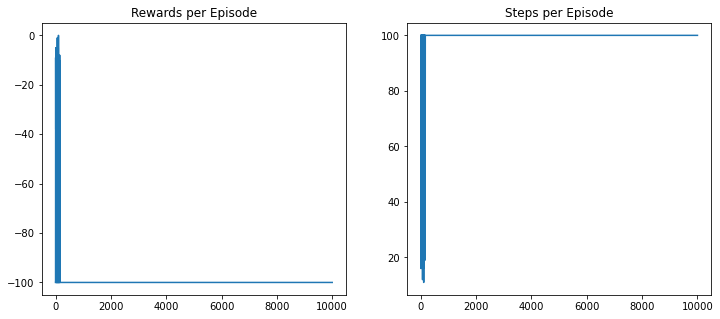

In [140]:
env = GridWorld(grid_size=(5,5), prob_obstacle=0.1)
agent = QLearningAgent(grid_size=(5,5))
    
rewards, steps = train(env, agent, episodes=10000, max_steps=100)
plot_training_progress(rewards, steps)

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 0.00%


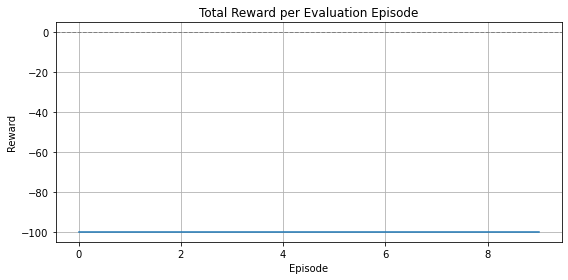

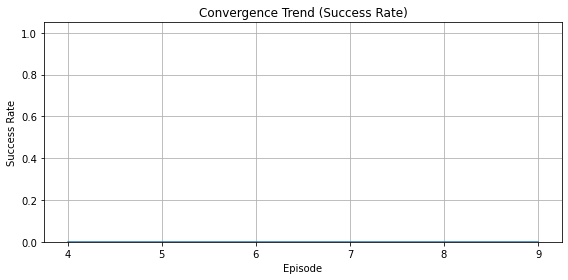

In [141]:
r, s, succ = evaluate(env, agent, episodes=10)
plot_rewards(r)
plot_convergence(succ)

Gamma increase
set gamma to .5 so that future rewards weigh more than immediate rewards

In [153]:
gamma_agent = QLearningAgent(grid_size=(5,5), gamma=.99)
    
rewards, steps = train(env, gamma_agent, episodes=10000)

Episode 250/10000 | Avg Reward: -14.61 | Avg Steps: 24.64 | Epsilon: 0.0000
Episode 500/10000 | Avg Reward: -15.38 | Avg Steps: 25.50 | Epsilon: 0.0000
Episode 750/10000 | Avg Reward: -22.33 | Avg Steps: 31.52 | Epsilon: 0.0000
Episode 1000/10000 | Avg Reward: -24.60 | Avg Steps: 33.71 | Epsilon: 0.0000
Episode 1250/10000 | Avg Reward: -24.73 | Avg Steps: 33.92 | Epsilon: 0.0000
Episode 1500/10000 | Avg Reward: -28.86 | Avg Steps: 37.53 | Epsilon: 0.0000
Episode 1750/10000 | Avg Reward: -29.51 | Avg Steps: 38.44 | Epsilon: 0.0000
Episode 2000/10000 | Avg Reward: -27.06 | Avg Steps: 35.86 | Epsilon: 0.0000
Episode 2250/10000 | Avg Reward: -34.32 | Avg Steps: 42.72 | Epsilon: 0.0000
Episode 2500/10000 | Avg Reward: -32.82 | Avg Steps: 41.23 | Epsilon: 0.0000
Episode 2750/10000 | Avg Reward: -34.42 | Avg Steps: 42.56 | Epsilon: 0.0000
Episode 3000/10000 | Avg Reward: -32.60 | Avg Steps: 40.92 | Epsilon: 0.0000
Episode 3250/10000 | Avg Reward: -41.94 | Avg Steps: 49.11 | Epsilon: 0.0000
Ep

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 40.00%


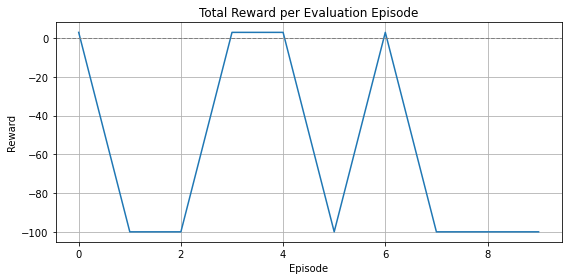

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 40.00%


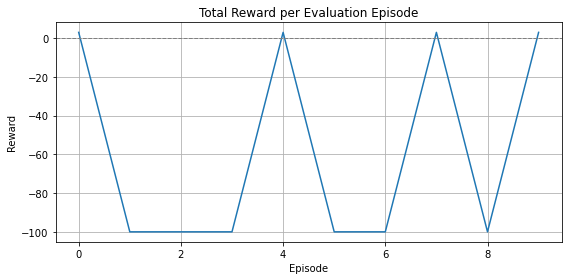

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 60.00%


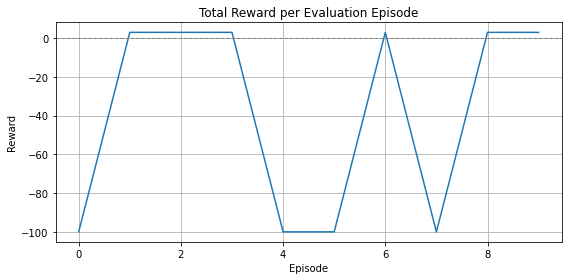

In [154]:
r, s, succ = evaluate(env, gamma_agent, episodes=10)
plot_rewards(r)
r, s, succ = evaluate(env, gamma_agent, episodes=10)
plot_rewards(r)
r, s, succ = evaluate(env, gamma_agent, episodes=10)
plot_rewards(r)

Model is inconcistent, but now makes predictions. 

Now tune only learning rate hyperparameter alpha to see its effect.
Take half of the learning rate, .05

In [155]:
alpha_agent = QLearningAgent(grid_size=(5,5), alpha=.05, gamma=.99)
    
rewards, steps = train(env, alpha_agent, episodes=10000)

Episode 250/10000 | Avg Reward: -16.69 | Avg Steps: 26.72 | Epsilon: 0.0000
Episode 500/10000 | Avg Reward: -13.46 | Avg Steps: 23.40 | Epsilon: 0.0000
Episode 750/10000 | Avg Reward: -17.19 | Avg Steps: 27.00 | Epsilon: 0.0000
Episode 1000/10000 | Avg Reward: -19.42 | Avg Steps: 29.01 | Epsilon: 0.0000
Episode 1250/10000 | Avg Reward: -21.93 | Avg Steps: 31.26 | Epsilon: 0.0000
Episode 1500/10000 | Avg Reward: -23.18 | Avg Steps: 32.64 | Epsilon: 0.0000
Episode 1750/10000 | Avg Reward: -25.76 | Avg Steps: 34.78 | Epsilon: 0.0000
Episode 2000/10000 | Avg Reward: -24.25 | Avg Steps: 33.44 | Epsilon: 0.0000
Episode 2250/10000 | Avg Reward: -29.30 | Avg Steps: 37.75 | Epsilon: 0.0000
Episode 2500/10000 | Avg Reward: -26.22 | Avg Steps: 35.46 | Epsilon: 0.0000
Episode 2750/10000 | Avg Reward: -28.25 | Avg Steps: 37.18 | Epsilon: 0.0000
Episode 3000/10000 | Avg Reward: -30.19 | Avg Steps: 38.82 | Epsilon: 0.0000
Episode 3250/10000 | Avg Reward: -28.94 | Avg Steps: 37.66 | Epsilon: 0.0000
Ep

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 40.00%


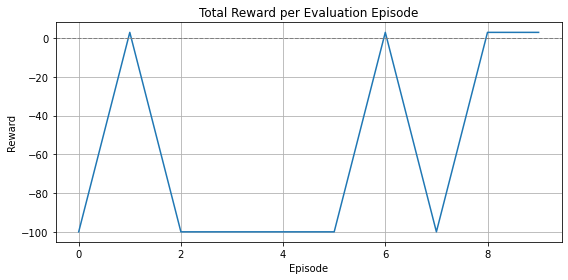

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 30.00%


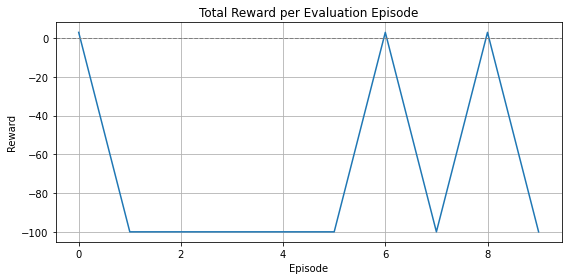

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 50.00%


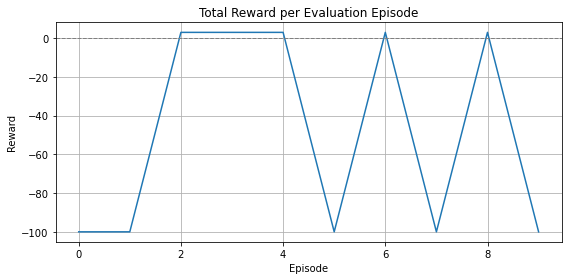

In [156]:
r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

Now tune with a higher learining rate

In [157]:
alpha_agent = QLearningAgent(grid_size=(5,5), alpha=.15, gamma=.99)
    
rewards, steps = train(env, alpha_agent, episodes=10000)

Episode 250/10000 | Avg Reward: -17.49 | Avg Steps: 27.52 | Epsilon: 0.0000
Episode 500/10000 | Avg Reward: -22.58 | Avg Steps: 31.82 | Epsilon: 0.0000
Episode 750/10000 | Avg Reward: -24.34 | Avg Steps: 33.72 | Epsilon: 0.0000
Episode 1000/10000 | Avg Reward: -30.26 | Avg Steps: 39.01 | Epsilon: 0.0000
Episode 1250/10000 | Avg Reward: -27.96 | Avg Steps: 36.67 | Epsilon: 0.0000
Episode 1500/10000 | Avg Reward: -34.62 | Avg Steps: 43.24 | Epsilon: 0.0000
Episode 1750/10000 | Avg Reward: -32.85 | Avg Steps: 41.17 | Epsilon: 0.0000
Episode 2000/10000 | Avg Reward: -34.24 | Avg Steps: 42.55 | Epsilon: 0.0000
Episode 2250/10000 | Avg Reward: -38.97 | Avg Steps: 46.54 | Epsilon: 0.0000
Episode 2500/10000 | Avg Reward: -43.32 | Avg Steps: 50.80 | Epsilon: 0.0000
Episode 2750/10000 | Avg Reward: -41.53 | Avg Steps: 48.96 | Epsilon: 0.0000
Episode 3000/10000 | Avg Reward: -40.71 | Avg Steps: 48.54 | Epsilon: 0.0000
Episode 3250/10000 | Avg Reward: -41.69 | Avg Steps: 48.95 | Epsilon: 0.0000
Ep

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 50.00%


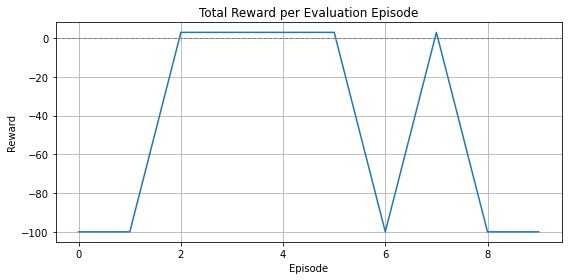

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 60.00%


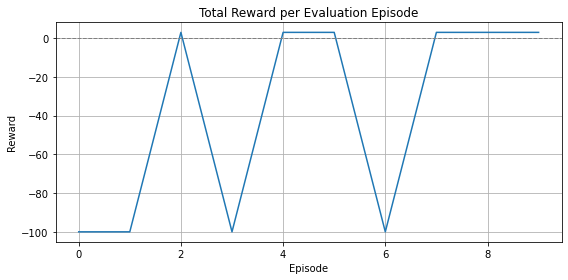

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 30.00%


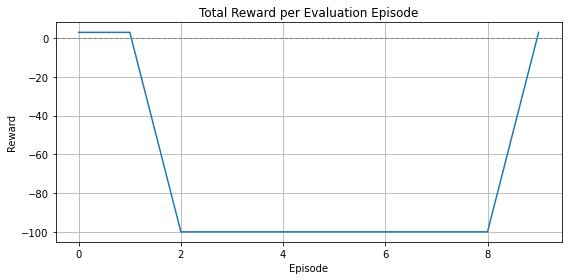

In [158]:
r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, alpha_agent, episodes=10)
plot_rewards(r)

Slower learning rate has better results

Now we will tune epsilon, the default value is 0. so lets try an exploration approach by setting it to 1 and its decay to .9

In [159]:
epsilon_agent = QLearningAgent(grid_size=(5,5), gamma=.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9)
    
rewards, steps = train(env, epsilon_agent, episodes=10000)

Episode 250/10000 | Avg Reward: -15.62 | Avg Steps: 25.69 | Epsilon: 0.0097
Episode 500/10000 | Avg Reward: -13.49 | Avg Steps: 23.66 | Epsilon: 0.0097
Episode 750/10000 | Avg Reward: -22.28 | Avg Steps: 31.82 | Epsilon: 0.0097
Episode 1000/10000 | Avg Reward: -22.51 | Avg Steps: 32.06 | Epsilon: 0.0097
Episode 1250/10000 | Avg Reward: -24.62 | Avg Steps: 34.03 | Epsilon: 0.0097
Episode 1500/10000 | Avg Reward: -24.57 | Avg Steps: 34.16 | Epsilon: 0.0097
Episode 1750/10000 | Avg Reward: -24.95 | Avg Steps: 34.24 | Epsilon: 0.0097
Episode 2000/10000 | Avg Reward: -25.57 | Avg Steps: 34.90 | Epsilon: 0.0097
Episode 2250/10000 | Avg Reward: -26.93 | Avg Steps: 36.26 | Epsilon: 0.0097
Episode 2500/10000 | Avg Reward: -25.15 | Avg Steps: 34.65 | Epsilon: 0.0097
Episode 2750/10000 | Avg Reward: -31.82 | Avg Steps: 40.62 | Epsilon: 0.0097
Episode 3000/10000 | Avg Reward: -34.10 | Avg Steps: 42.82 | Epsilon: 0.0097
Episode 3250/10000 | Avg Reward: -31.58 | Avg Steps: 40.34 | Epsilon: 0.0097
Ep

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 60.00%


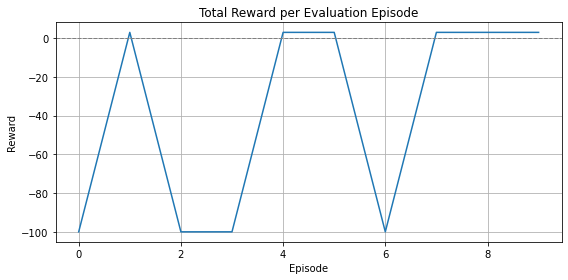

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 40.00%


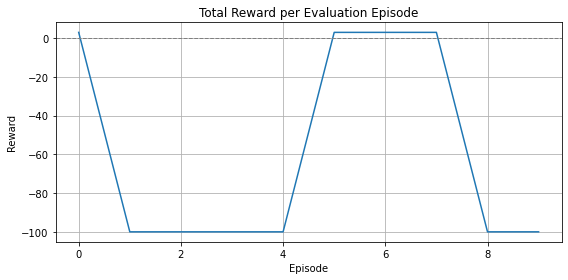

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 40.00%


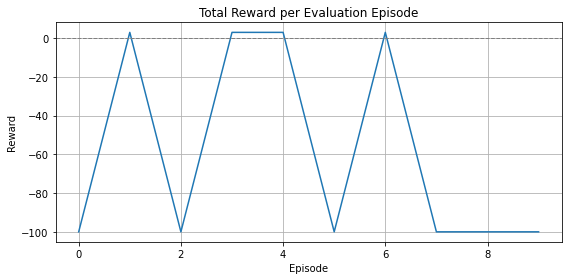

In [160]:
r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

Agent stops exploring very early due to it decaying too quickly

Slow down decay by increasing epsilon to .999

In [161]:
epsilon_agent = QLearningAgent(grid_size=(5,5), gamma=.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999)
    
rewards, steps = train(env, epsilon_agent, episodes=10000)

Episode 250/10000 | Avg Reward: -45.14 | Avg Steps: 54.20 | Epsilon: 0.7787
Episode 500/10000 | Avg Reward: -22.85 | Avg Steps: 33.15 | Epsilon: 0.6064
Episode 750/10000 | Avg Reward: -15.20 | Avg Steps: 25.59 | Epsilon: 0.4722
Episode 1000/10000 | Avg Reward: -11.93 | Avg Steps: 22.44 | Epsilon: 0.3677
Episode 1250/10000 | Avg Reward: -10.53 | Avg Steps: 21.18 | Epsilon: 0.2863
Episode 1500/10000 | Avg Reward: -9.85 | Avg Steps: 20.45 | Epsilon: 0.2230
Episode 1750/10000 | Avg Reward: -13.84 | Avg Steps: 23.96 | Epsilon: 0.1736
Episode 2000/10000 | Avg Reward: -16.86 | Avg Steps: 26.85 | Epsilon: 0.1352
Episode 2250/10000 | Avg Reward: -16.13 | Avg Steps: 26.08 | Epsilon: 0.1053
Episode 2500/10000 | Avg Reward: -18.65 | Avg Steps: 28.59 | Epsilon: 0.0820
Episode 2750/10000 | Avg Reward: -18.25 | Avg Steps: 28.06 | Epsilon: 0.0638
Episode 3000/10000 | Avg Reward: -20.39 | Avg Steps: 30.29 | Epsilon: 0.0497
Episode 3250/10000 | Avg Reward: -19.00 | Avg Steps: 29.08 | Epsilon: 0.0387
Epi

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 60.00%


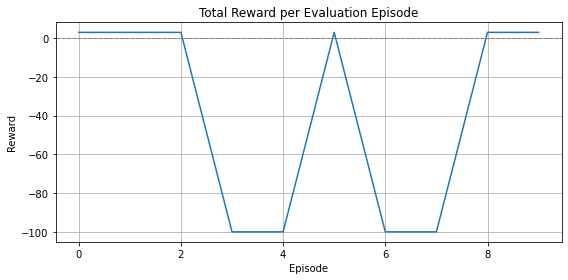

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 80.00%


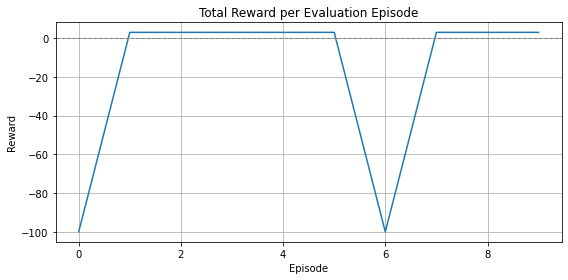

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 60.00%


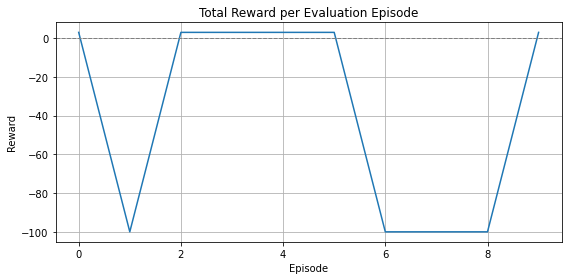

In [162]:
r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

In [165]:
epsilon_agent = QLearningAgent(grid_size=(5,5), gamma=.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9999)
    
rewards, steps = train(env, epsilon_agent, episodes=20000)

Episode 250/20000 | Avg Reward: -64.71 | Avg Steps: 71.40 | Epsilon: 0.9753
Episode 500/20000 | Avg Reward: -59.52 | Avg Steps: 66.86 | Epsilon: 0.9512
Episode 750/20000 | Avg Reward: -57.42 | Avg Steps: 65.29 | Epsilon: 0.9277
Episode 1000/20000 | Avg Reward: -54.13 | Avg Steps: 62.36 | Epsilon: 0.9048
Episode 1250/20000 | Avg Reward: -45.96 | Avg Steps: 54.98 | Epsilon: 0.8825
Episode 1500/20000 | Avg Reward: -41.86 | Avg Steps: 51.45 | Epsilon: 0.8607
Episode 1750/20000 | Avg Reward: -41.21 | Avg Steps: 50.54 | Epsilon: 0.8394
Episode 2000/20000 | Avg Reward: -35.22 | Avg Steps: 45.26 | Epsilon: 0.8187
Episode 2250/20000 | Avg Reward: -32.26 | Avg Steps: 42.21 | Epsilon: 0.7985
Episode 2500/20000 | Avg Reward: -31.10 | Avg Steps: 41.27 | Epsilon: 0.7788
Episode 2750/20000 | Avg Reward: -28.90 | Avg Steps: 39.06 | Epsilon: 0.7596
Episode 3000/20000 | Avg Reward: -26.13 | Avg Steps: 36.47 | Epsilon: 0.7408
Episode 3250/20000 | Avg Reward: -27.26 | Avg Steps: 37.43 | Epsilon: 0.7225
Ep

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 70.00%


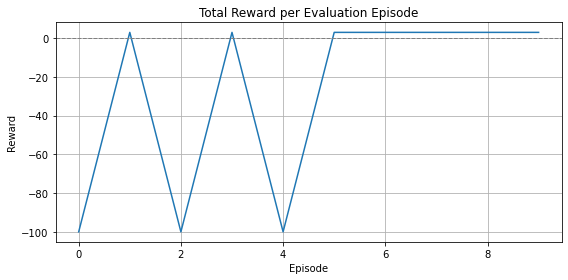

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: -100 | Steps: 100

Success Rate: 50.00%


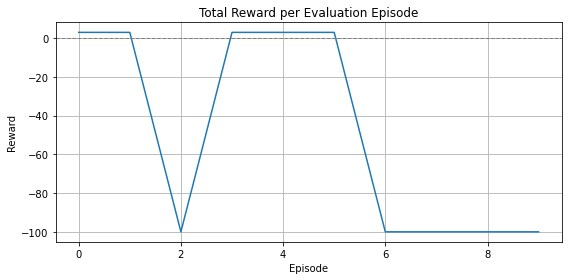

Episode 1/10 | Reward: -100 | Steps: 100
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: -100 | Steps: 100
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 70.00%


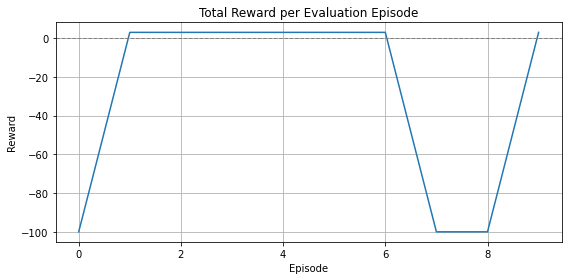

In [166]:
r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, epsilon_agent, episodes=10)
plot_rewards(r)

Combine slow deteration approach with a slower learning rate

In [195]:
slow_agent = QLearningAgent(grid_size=(5,5), alpha=.4, gamma=.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9999)
    
rewards, steps = train(env, slow_agent, episodes=15000)

Episode 250/15000 | Avg Reward: -67.17 | Avg Steps: 73.11 | Epsilon: 0.9753
Episode 500/15000 | Avg Reward: -61.60 | Avg Steps: 68.50 | Epsilon: 0.9512
Episode 750/15000 | Avg Reward: -57.62 | Avg Steps: 65.23 | Epsilon: 0.9277
Episode 1000/15000 | Avg Reward: -52.20 | Avg Steps: 60.25 | Epsilon: 0.9048
Episode 1250/15000 | Avg Reward: -47.74 | Avg Steps: 56.67 | Epsilon: 0.8825
Episode 1500/15000 | Avg Reward: -43.47 | Avg Steps: 52.84 | Epsilon: 0.8607
Episode 1750/15000 | Avg Reward: -38.61 | Avg Steps: 48.29 | Epsilon: 0.8394
Episode 2000/15000 | Avg Reward: -36.13 | Avg Steps: 45.94 | Epsilon: 0.8187
Episode 2250/15000 | Avg Reward: -30.66 | Avg Steps: 41.00 | Epsilon: 0.7985
Episode 2500/15000 | Avg Reward: -33.28 | Avg Steps: 43.27 | Epsilon: 0.7788
Episode 2750/15000 | Avg Reward: -29.93 | Avg Steps: 40.27 | Epsilon: 0.7596
Episode 3000/15000 | Avg Reward: -23.18 | Avg Steps: 33.74 | Epsilon: 0.7408
Episode 3250/15000 | Avg Reward: -26.76 | Avg Steps: 37.06 | Epsilon: 0.7225
Ep

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: -100 | Steps: 100
Episode 3/10 | Reward: -100 | Steps: 100
Episode 4/10 | Reward: -100 | Steps: 100
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: -100 | Steps: 100
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 40.00%


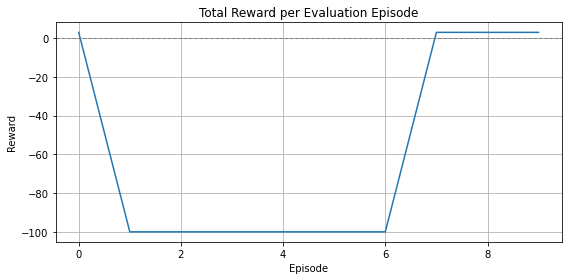

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: -100 | Steps: 100
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: 3 | Steps: 8
Episode 8/10 | Reward: 3 | Steps: 8
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 90.00%


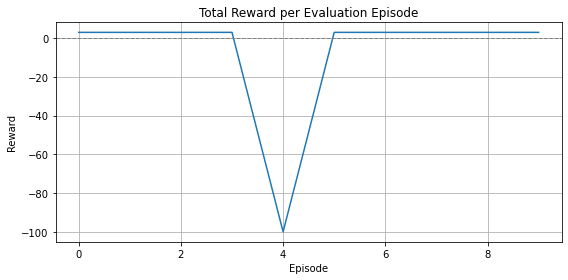

Episode 1/10 | Reward: 3 | Steps: 8
Episode 2/10 | Reward: 3 | Steps: 8
Episode 3/10 | Reward: 3 | Steps: 8
Episode 4/10 | Reward: 3 | Steps: 8
Episode 5/10 | Reward: 3 | Steps: 8
Episode 6/10 | Reward: 3 | Steps: 8
Episode 7/10 | Reward: -100 | Steps: 100
Episode 8/10 | Reward: -100 | Steps: 100
Episode 9/10 | Reward: 3 | Steps: 8
Episode 10/10 | Reward: 3 | Steps: 8

Success Rate: 80.00%


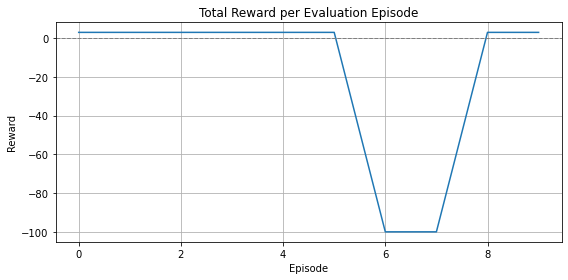

In [196]:
r, s, succ = evaluate(env, slow_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, slow_agent, episodes=10)
plot_rewards(r)

r, s, succ = evaluate(env, slow_agent, episodes=10)
plot_rewards(r)